# The PMP model for the Optimal Scenario (Colab version)
- new amenities + existing amenities





## 0. Load the library


In [2]:
! pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 82.5 MB/s eta 0:00:00


In [3]:
! pip install --upgrade fiona
! pip install --upgrade pyproj

In [4]:
! pip install networkx
! pip install mapclassify
! pip install matplotlib-scalebar

In [5]:

import pandas as pd
import geopandas as gpd
from itertools import product
import networkx as nx
import gurobipy as gp
import numpy as np
from math import sqrt
import random
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import unary_union
from geopy.distance import distance
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist

In [11]:
# Create an environment with the WLS license
# Link: https://www.gurobi.com/academia/academic-program-and-licenses/
params = {
"WLSACCESSID": '',
"WLSSECRET": '',
"LICENSEID":,# is the numebr
}
env = gp.Env(params=params)



Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2537386
Academic license 2537386 - for non-commercial use only - registered to uc___@ucl.ac.uk


## 1. Load the dataset
1. Retrieve the location of a new amenities
  - Geographical constraints:  

   (a) Within Greater London boundary.

   [File Name: london_boundary, lb.geojson ].

   (b) Located outside the following areas:
   - Conservation Areas;
   - Designated Open Areas;
   - Sites of Importance for Nature Conservation (SINCs).  
   [File Name: dis, dissolve.geojson]
  - The Relationship between Amenities.  
  (a) The distance between new amenities and existing amenities is greater than 800 meters;
  
  (b) The distance between new amenities is greater than 800 meters;   
  (c) Amenities with the same type cannot overlap.  
  [File Name: existing_amenities, poi_name.geojson]
1. Build the PMP model
- Demand Point: centroid of origin hexagon  

 [File Name: origin points, unique_ori.geojson]
- facility_points: new amenities + existing amenities




In [12]:
# Geographical constraints
dis= gpd.read_file('/content/drive/MyDrive/data_thesis/P_test/dissolve.geojson')
dis = dis.to_crs('EPSG:27700')

In [13]:
# existing POI
file_path = '/content/drive/MyDrive/data_thesis/P_test/poi_name.geojson'
poi = gpd.read_file(file_path)
poi = poi.to_crs('EPSG:27700')
# select a type of amenities: taking entertainment as the example
poi_ent= poi[poi['poi_name']=='Entertainment']

In [15]:
# orign Points
file_path = '/content/drive/MyDrive/data_thesis/P_test/unique_ori.geojson'
unique_ori= gpd.read_file(file_path)
unique_ori = unique_ori.to_crs('EPSG:27700')
demand_points = unique_ori['geometry'].to_list()

In [16]:
london_boundary = gpd.read_file('/content/drive/MyDrive/data_thesis/r5r_facilities/lb.geojson')
# Defining London's boundaries
london_boundary_polygon = london_boundary.geometry.unary_union

## 2. Retrieve the location of a new amenities

In [78]:
num_new_points = 31 # new (Entertainment)
new_points = []

while len(new_points) < num_new_points:
    # Randomly generate new points within the London boundaries
    min_x, max_x = london_boundary.total_bounds[0], london_boundary.total_bounds[2]
    min_y, max_y = london_boundary.total_bounds[1], london_boundary.total_bounds[3]
    new_x = np.random.uniform(min_x, max_x)
    new_y = np.random.uniform(min_y, max_y)
    new_point = Point(new_x, new_y)

    # Check if the new point is within the restricted area
    if any(new_point.within(area) for area in dis.geometry):
        continue  # If the point is within the restricted area, skip

    # Check if the new point overlaps with an existing point
    # change the poi_ent['geometry'] name
    overlaps_existing = False
    for existing_point in poi_ent['geometry']:
        if new_point.distance(existing_point) <= 800:  # Distance less than 800 meters - Overlap
            overlaps_existing = True
            break

    # Check if the new point is greater than 800 meters away from other new points
    if not overlaps_existing:
        if all(new_point.distance(p) > 800 for p in new_points):
            if new_point.within(london_boundary_polygon):
                new_points.append(new_point)


In [79]:
# create the new points into df (for save)
new_data = {
    'poi_name': ['New Sports Facility'] * num_new_points,
    'geometry': new_points
}
new_df = gpd.GeoDataFrame(new_data, crs='EPSG:27700')

In [29]:
# save the new points to local
#new_df.to_file('/content/drive/MyDrive/data_thesis/P_test/res_4/new_ent.geojson', driver='GeoJSON')

In [80]:
# create the label for existing points
poi_ent['type'] = 'existing'
# create a dataframe to conbime the new and existing point
new_points_df = pd.DataFrame({'geometry': new_points, 'type': 'new'})
combined_df = pd.concat([poi_ent, new_points_df], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [102]:
#Since there are fewer existing entertainment facilities and the number of newly selected facilities is also small,
# the conditions for facility location selection are less restrictive,
# resulting in slightly different results each time.
# Therefore, this study saves a better result as the final selection point.


#However, the existing number of other facilities is large,
# and the difference between each generation is small under the selection of constraints.

#file_path = '/content/drive/MyDrive/data_thesis/P_test/res_3/new_ent.geojson'
#new = gpd.read_file(file_path)
#new = new.to_crs('EPSG:27700')
#combined_df = pd.concat([poi_ent, new], ignore_index=True)
#combined_df = gpd.GeoDataFrame(combined_df, geometry='geometry')

In [103]:
# check the results
combined_df

,id,ref_no,name,pointx_cla,groupname,categoryna,classname,feature_ea,feature_no,pos_accura,...,telephone_,url,brand,qualifier_,qualifie_1,provenance,supply_dat,poi_name,geometry,type
0,129390.0,97771435.0,Odeon Cinemas,04250308,Entertainment,"Venues, Stage and Screen",Cinemas,518370.2,169447.6,1.0,...,03330067777,www.odeon.co.uk,Odeon Cinemas,None,None,118 Information,2023-03-01,Entertainment,POINT (518370.200 169447.600),existing
1,317132.0,129883942.0,The David Lean Cinema,04250308,Entertainment,"Venues, Stage and Screen",Cinemas,532357.0,165384.0,1.0,...,None,None,None,None,None,Local Data Company,2023-03-01,Entertainment,POINT (532357.000 165384.000),existing
2,68026.0,49740918.0,Odeon Cinemas,04250308,Entertainment,"Venues, Stage and Screen",Cinemas,537014.0,169384.0,1.0,...,03330067777,www.odeon.co.uk,Odeon Cinemas,None,None,118 Information,2023-03-01,Entertainment,POINT (537014.000 169384.000),existing
3,330935.0,160713708.0,Everyman Cinemas,04250308,Entertainment,"Venues, Stage and Screen",Cinemas,533664.0,170639.0,1.0,...,08724369060,www.everymancinema.com,Everyman,None,None,Local Data Company,2023-03-01,Entertainment,POINT (533664.000 170639.000),existing
4,209251.0,149626905.0,Vue Cinemas,04250308,Entertainment,"Venues, Stage and Screen",Cinemas,530624.0,166010.0,1.0,...,03453084620,www.myvue.com,Vue Cinemas,None,None,118 Information,2023-03-01,Entertainment,POINT (530624.000 166010.000),existing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Sports Facility,POINT (548835.089 176489.546),NaN
173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Sports Facility,POINT (524722.792 165842.415),NaN
174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Sports Facility,POINT (547785.765 174177.420),NaN
175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Sports Facility,POINT (508208.776 190872.816),NaN


In [104]:
# define the facilities points
facility_points = combined_df['geometry'].to_list()


In [105]:
# save the results
#combined_df = gpd.GeoDataFrame(combined_df, geometry='geometry')
#combined_df.to_file('/content/drive/MyDrive/data_thesis/P_test/optimal_ent.geojson', driver='GeoJSON')

## 3. Build the PMP Model


In [106]:
# build the model
m = gp.Model("p-median Problem", env=env)

In [107]:
# create variables
select = m.addVars(len(facility_points), vtype=GRB.BINARY, name='Select')  # X
cartesian_prod = list(product(range(len(demand_points)), range(len(facility_points))))
assign = m.addVars(cartesian_prod, vtype=GRB.BINARY, name='Assign')  # Y


In [108]:
# create constraint
num_located =177 # the number of total facilities
m.addConstr((quicksum(select[j] for j in range(len(facility_points))) == num_located), name='Num_limit')
m.addConstrs((assign[i, j] <= select[j] for i, j in cartesian_prod), name='Assign_before_locate') # very demand points will be distributed to one faclities
m.addConstrs((quicksum(assign[i, j] for j in range(len(facility_points))) == 1 for i in range(len(demand_points))), name='Unique_assign')


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>,
 11: <gurobi.Constr *Awaiting Model Update*>,
 12: <gurobi.Constr *Awaiting Model Update*>,
 13: <gurobi.Constr *Awaiting Model Update*>,
 14: <gurobi.Constr *Awaiting Model Update*>,
 15: <gurobi.Constr *Awaiting Model Update*>,
 16: <gurobi.Constr *Awaiting Model Update*>,
 17: <gurobi.Constr *Awaiting Model Update*>,
 18: <gurobi.Constr *Awaiting Model Update*>,
 19: <gurobi.Constr *Awaiting Model Update*>,
 20: <gurobi.Constr *Awaiting Model Update*>,
 21: <gurobi.Constr *Awaiting Model Update*>

In [109]:
# calculate the distance
def compute_distance(loc1, loc2):
    return loc1.distance(loc2)

dist = {(i, j): compute_distance(demand_points[i], facility_points[j]) for i, j in cartesian_prod}


In [110]:
# set the objective
m.setObjective(quicksum(dist[i, j] * assign[i, j] for i, j in cartesian_prod), GRB.MINIMIZE)

In [111]:
# run the optimised model
m.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Academic license 2537386 - for non-commercial use only - registered to uc___@ucl.ac.uk
Optimize a model with 443577 rows, 441261 columns and 1323429 nonzeros
Model fingerprint: 0x6bc1946d
Variable types: 0 continuous, 441261 integer (441261 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 6e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+02]
Found heuristic solution: objective 4.615490e+07
Presolve removed 441085 rows and 177 columns
Presolve time: 0.53s
Presolved: 2492 rows, 441084 columns, 441084 nonzeros
Variable types: 0 continuous, 441084 integer (441084 binary)
Found heuristic solution: objective 5552953.9650

Explored 1 nodes (0 simplex iterations) in 1.20 seconds (0.48 work units)
Th

In [112]:
# print the results
selected_facilities = [j for j in range(len(facility_points)) if select[j].x > 0]
assigned_relationships = [(i, j) for (i, j) in cartesian_prod if assign[i, j].x > 0.5]
print("Selected positions = ", selected_facilities)
print("Assigned relationships = ", assigned_relationships)
print('Objvalue = %g' % m.objVal)

Selected positions =  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176]
Assigned relationships =  [(0, 1), (1, 1), (2, 73), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 73), (15, 73), (16, 73), (17, 73), (18, 73), (19, 73)

### 3.1 Visualised the initial results

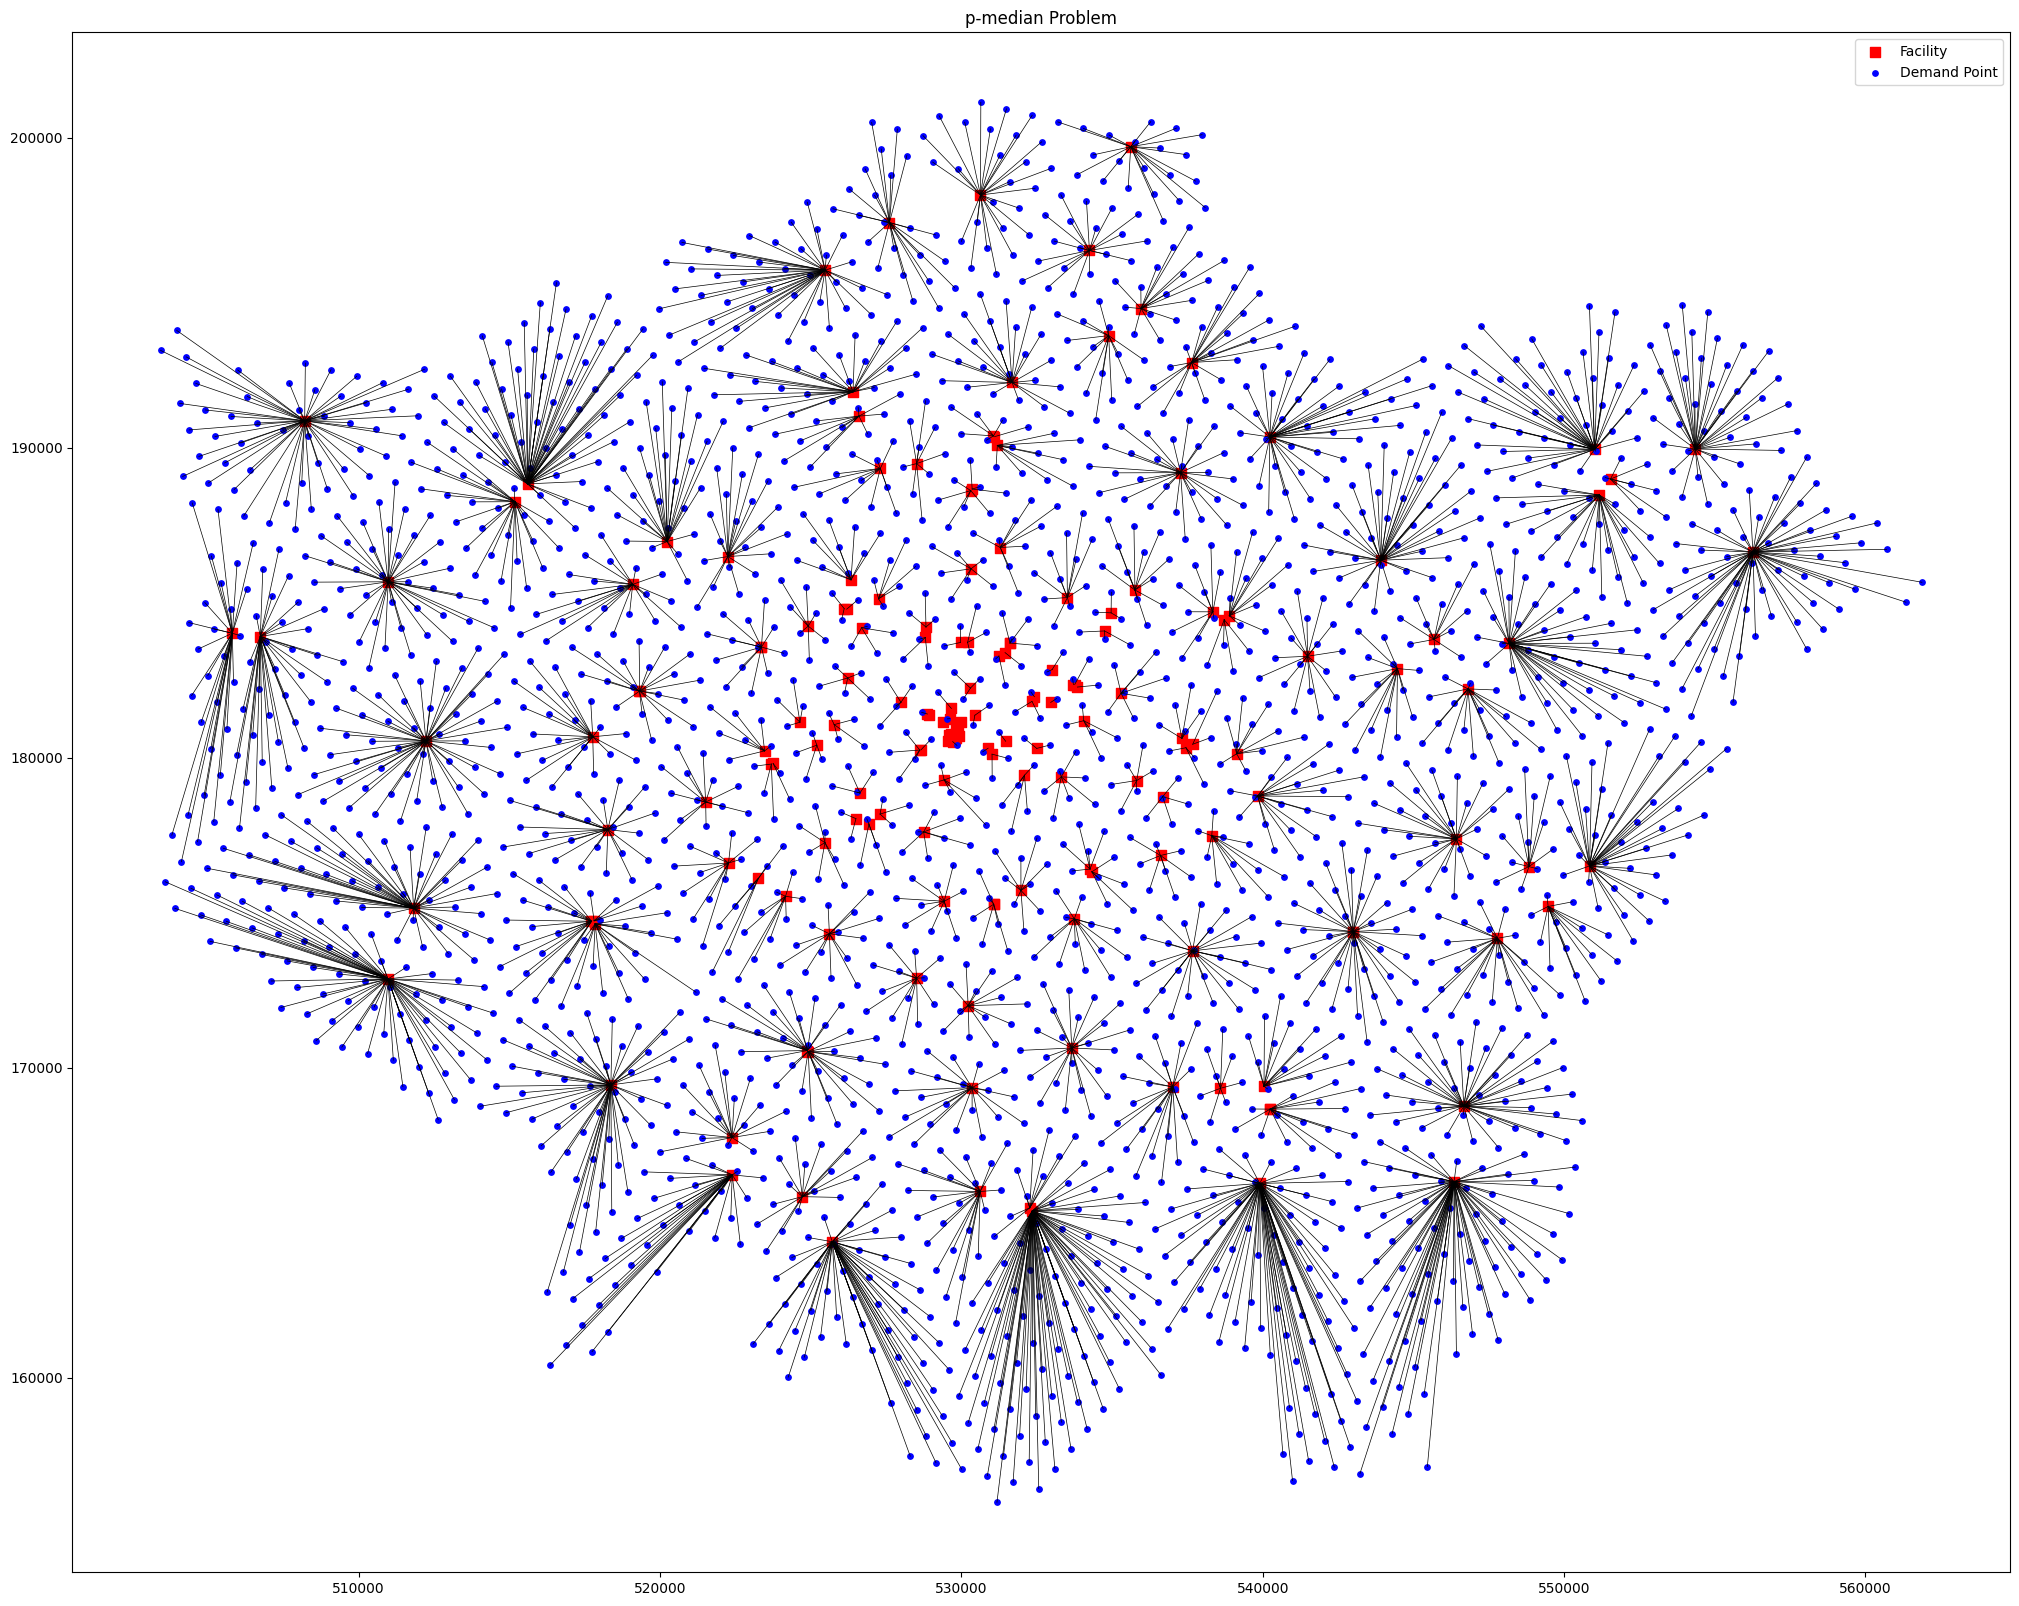

In [113]:
# Drawing (adjust according to actual situation)
plt.figure(figsize=(25, 20))
plt.title('p-median Problem')

# Drawing existing amenities
facility_x = [p.x for p in facility_points]
facility_y = [p.y for p in facility_points]
plt.scatter(facility_x, facility_y, c='Red', marker='s', s=50, label='Facility')

# Draw demand points
demand_x = [p.x for p in demand_points]
demand_y = [p.y for p in demand_points]
plt.scatter(demand_x, demand_y, c='Blue', marker='o', s=15, label='Demand Point')

# Draw the connection line of the allocation relationship
for (i, j) in assigned_relationships:
    plt.plot([demand_points[i].x, facility_points[j].x], [demand_points[i].y, facility_points[j].y], c='Black', linewidth=0.5)

plt.grid(False)
plt.legend(loc='best', fontsize=10)
plt.show()

### 3.2 Drawing the optimal results (improved)

In [114]:
df_assigned_relationships = pd.DataFrame(assigned_relationships, columns=['Demand', 'Assigned_facilities'])
# Add distance information to DataFrame
df_assigned_relationships['Distance'] = [dist.get((i, j), None) for (i, j) in assigned_relationships]

df_assigned_relationships

,Demand,Assigned_facilities,Distance
0,0,1,5664.361060
1,1,1,6389.756989
2,2,73,5659.249845
3,3,1,6459.433233
4,4,1,4884.011516
...,...,...,...
2487,2487,158,820.676067
2488,2488,158,812.189995
2489,2489,158,622.478636
2490,2490,158,1047.723088


In [115]:

# Add demand point coordinates to DataFrame
df_assigned_relationships['Demand_Latitude'] = [demand_points[i].y for (i, _) in assigned_relationships]
df_assigned_relationships['Demand_Longitude'] = [demand_points[i].x for (i, _) in assigned_relationships]

# Create GeoDataFrame
df_assigned_relationships['geometry'] = [Point(demand_points[i].x, demand_points[i].y) for (i, _) in assigned_relationships]
gdf_assigned_relationships = gpd.GeoDataFrame(df_assigned_relationships, geometry='geometry')


In [116]:
# check the results
gdf_assigned_relationships

,Demand,Assigned_facilities,Distance,Demand_Latitude,Demand_Longitude,geometry
0,0,1,5664.361060,160052.356599,530444.262468,POINT (530444.262 160052.357)
1,1,1,6389.756989,159196.472541,530762.165110,POINT (530762.165 159196.473)
2,2,73,5659.249845,160262.140625,529591.550467,POINT (529591.550 160262.141)
3,3,1,6459.433233,159406.224994,529909.453542,POINT (529909.454 159406.225)
4,4,1,4884.011516,160698.414965,530979.008214,POINT (530979.008 160698.415)
...,...,...,...,...,...,...
2487,2487,158,820.676067,199029.086421,536069.780419,POINT (536069.780 199029.086)
2488,2488,158,812.189995,200093.653029,534901.441470,POINT (534901.441 200093.653)
2489,2489,158,622.478636,199240.045490,535218.922801,POINT (535218.923 199240.045)
2490,2490,158,1047.723088,200525.206824,536285.611181,POINT (536285.611 200525.207)


In [ ]:
# save the results
#gdf_assigned_relationships.to_file('/content/drive/MyDrive/data_thesis/P_test/res_3/dis_pot_ent.geojson', driver='GeoJSON')

In [117]:
# load the hexagons dataset
file_path = '/content/drive/MyDrive/data_thesis/r5r_facilities/level8_hexagons.geojson'
ori_hex= gpd.read_file(file_path)
ori = unique_ori.merge(ori_hex, left_on ="Origin_Hex8", right_on="hex_8",how='left' )

ori = ori.drop(columns=['geometry_x'])
ori = ori.rename(columns={'geometry_y': 'geometry'})
ori = gpd.GeoDataFrame(ori, geometry='geometry')
ori = ori.to_crs('EPSG:27700')

In [118]:
# combine the dataset
merged_gdf = ori.merge(df_assigned_relationships, left_index=True, right_index=True, how='left')
merged_gdf = merged_gdf.drop(columns=['geometry_y','Demand_Latitude','Demand_Longitude'])
merged_gdf = merged_gdf.rename(columns={'geometry_x': 'geometry'})
merged_gdf = gpd.GeoDataFrame(merged_gdf, geometry='geometry')
merged_gdf = merged_gdf.to_crs('EPSG:27700')
# Calculate the average distance for each assigned_facilities
average_distance = merged_gdf.groupby('Assigned_facilities')['Distance'].mean().reset_index()


In [119]:
assigned_relationship = merged_gdf.copy()

In [120]:
# defined the draw rule

# 1. Filter out numbers with a frequency of less than 3 and process them
def process_small_count_facilities(merged_gdf, average_distance):
    # Count the number of occurrences of each number in the Assigned_facilities column
    facility_counts = merged_gdf['Assigned_facilities'].value_counts()

    # Filter out numbers that appear less than 3 times
    facilities_to_keep = facility_counts[facility_counts < 3].index

    # Filter out the records with these numbers from merged_gdf
    filtered_gdf = merged_gdf[merged_gdf['Assigned_facilities'].isin(facilities_to_keep)]

    filtered_gdf = filtered_gdf.merge(average_distance, on='Assigned_facilities', how='left')
    filtered_gdf = filtered_gdf.rename(columns={'Distance_y': 'average_distance'})

    # Dissolve by 'Assigned_facilities'
    dissolved_sm = filtered_gdf.dissolve(by='Assigned_facilities', as_index=False)

    def smooth_polygon(polygon, buffer_distance=1.0):
        """Generate rounded polygons using a buffer"""
        return polygon.buffer(buffer_distance).buffer(-buffer_distance)

    # # Perform operations on dissolved_sm
    dissolved_sm['geometry'] = dissolved_sm['geometry'].apply(lambda geom: smooth_polygon(geom, buffer_distance=0.1))
    dissolved_sm = dissolved_sm.to_crs('EPSG:27700')

    # Drop specified columns and merge with average_distance
    drop_the_columns = ['Origin_Hex8', 'hex_8', 'Demand', 'Distance_x']
    dissolved = dissolved_sm.drop(columns=drop_the_columns)
    dissolved = dissolved.merge(average_distance, on='Assigned_facilities', how='left')
    dissolved = dissolved.rename(columns={'Distance_y': 'average_distance'})

    return dissolved

# 2. Filter out numbers that appear more than or equal to 3 times and process them
def process_large_count_facilities(gdf_assigned_relationships, average_distance):
    def create_convex_hull(points):
        if len(points) < 3:
            return None  # # Return None if the points are insufficient
        # Compute the convex hull
        return unary_union(points).convex_hull

    def smooth_polygon(polygon, tolerance=0.8):
        if polygon is not None:
            return polygon.simplify(tolerance)
        return polygon

    def add_buffer(polygon, buffer_distance):
        if polygon is not None:
            return polygon.buffer(buffer_distance)
        return polygon

    # Group Assigned_facilities and generate polygons
    polygons = []
    for facility_id, group in gdf_assigned_relationships.groupby('Assigned_facilities'):
        points = [Point(xy) for xy in zip(group['Demand_Longitude'], group['Demand_Latitude'])]
        convex_hull = create_convex_hull(points)
        smoothed_polygon = smooth_polygon(convex_hull, tolerance=1)
        if smoothed_polygon and smoothed_polygon.area > 0:  # Only add valid polygons
            buffered_polygon = add_buffer(smoothed_polygon, buffer_distance=300)  # Add buffer
            polygons.append({'Assigned_facilities': facility_id, 'geometry': buffered_polygon})

    # Create new GeoDataFrame
    polygon_gdf = gpd.GeoDataFrame(polygons, columns=['Assigned_facilities', 'geometry'])
    polygon_gdf = polygon_gdf.merge(average_distance, on='Assigned_facilities', how='left')
    polygon_gdf = polygon_gdf.rename(columns={'Distance': 'average_distance'})

    return polygon_gdf

# 3. Combine the results of step 1 and step 2
def merge_results(dissolved, polygon_gdf):
    merged = pd.concat([dissolved, polygon_gdf], ignore_index=True)
    return merged

# Define Main Script
def main(merged_gdf, gdf_assigned_relationships, average_distance):
    dissolved = process_small_count_facilities(merged_gdf, average_distance)
    polygon_gdf = process_large_count_facilities(gdf_assigned_relationships, average_distance)
    final_result = merge_results(dissolved, polygon_gdf)
    return final_result

In [121]:
# Run the draw rule
final_result = main(merged_gdf, gdf_assigned_relationships, average_distance)
final_result

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:1486: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as OSGB36 / British National Grid (the single non-null crs provided).
  warnings.warn(


,Assigned_facilities,geometry,average_distance,Distance
0,36,"POLYGON ((531628.895 180479.852, 531628.895 18...",487.924547,487.924547
1,41,"POLYGON ((528538.531 180466.746, 528538.531 18...",493.750947,493.750947
2,42,"POLYGON ((529390.652 180256.300, 529390.652 18...",186.315546,186.315546
3,43,"POLYGON ((530560.401 179190.996, 530560.401 17...",669.201987,669.201987
4,44,"POLYGON ((530242.701 180045.872, 530242.701 18...",219.918247,219.918247
...,...,...,...,...
156,172,"POLYGON ((548811.475 175584.380, 548790.807 17...",1465.698516,NaN
157,173,"POLYGON ((523692.591 163843.906, 523668.218 16...",1529.407851,NaN
158,174,"POLYGON ((546234.798 171399.587, 546210.152 17...",1759.307200,NaN
159,175,"POLYGON ((508040.732 187116.776, 508015.495 18...",2709.300136,NaN


Visualised the optimal results
- load the lirary


Drawing


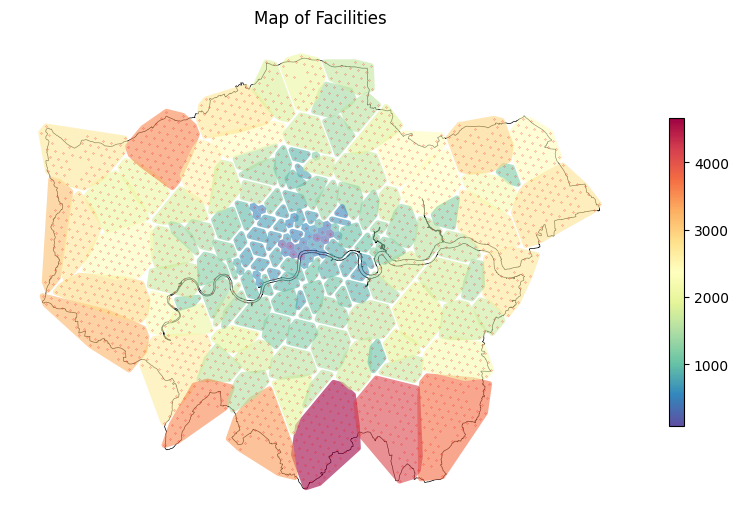

In [122]:
# Visualizing polygons
fig, ax = plt.subplots(figsize=(10, 10))

#poi_sport.plot(column='poi_name', ax=ax, legend=True, cmap='viridis',markersize=1)
london_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, aspect='equal')#,alpha=0.7)
#merged.plot(column= 'average_distance',ax=ax,  cmap='viridis', edgecolor='grey')
final_result.plot(
    column='average_distance',
    ax=ax,
    cmap='Spectral_r', #Spectral_r #YlOrRd
    #edgecolor=None,
    alpha=0.6,
    legend=True,
    legend_kwds={'shrink': 0.4}
)

unique_ori.plot(ax=ax, color='red', markersize=0.03, label='Existing Facilities')
ax.set_title('Map of Facilities')
ax.set_axis_off()

plt.show()

In [ ]:
# Save the results
#final_result.to_file('/content/drive/MyDrive/data_thesis/P_test/res_3/opt_res_ent.geojson', driver='GeoJSON')

## 4. The Local Search Strategy

In [ ]:
# Exporting the results of the optimization model
selected_facilities = [j for j in range(len(facility_points)) if select[j].x > 0]
assigned_relationships = [(i, j) for (i, j) in cartesian_prod if assign[i, j].x > 0.5]

In [ ]:
# Get a list of all facilities
all_facilities = combined_df['geometry'].to_list()

# Filter out the new amenities
replaceable_facilities = [facility for facility in all_facilities if not any(facility.within(poi_geom) for poi_geom in poi_ent['geometry'])]

In [ ]:

new_points = []


# define restricted area
def validate_new_point(facility, new_points):
    if any(facility.within(area) for area in dis.geometry):
        return False
    if any(facility.distance(existing) <= 800 for existing in poi_ph['geometry']):
        return False
    if any(facility.distance(new) <= 800 for new in new_points):
        return False
    return True

def generate_new_points_around_facilities(replaceable_facilities, num_new_points, radius=800):
    global new_points
    new_points = []
    for facility in replaceable_facilities:
        # Generate new points in the area near the new facility points
        min_x, min_y, max_x, max_y = facility.buffer(radius).bounds
        for _ in range(num_new_points):
            new_x = np.random.uniform(min_x, max_x)
            new_y = np.random.uniform(min_y, max_y)
            new_point = Point(new_x, new_y)
            if validate_new_point(new_point, new_points):
                new_points.append(new_point)
    return new_points

def compute_objective(facility_points, demand_points, distances):
    # For each demand point, find the minimum distance to the facility point
    min_distances = []
    for i, demand_point in enumerate(demand_points):
        nearest_distance = min(distances[i][j] for j in range(len(facility_points)))
        min_distances.append(nearest_distance)

    # Return the maximum of these minimum distances
    return max(min_distances)


In [33]:
import pandas as pd
import numpy as np
import random
from shapely.geometry import Point
import geopandas as gpd
# the local research strategy
def local_search(facility_points, demand_points, distances, replaceable_facilities, num_iterations=10):
    best_facility_points = list(facility_points)
    best_objective_value = compute_objective(best_facility_points, demand_points, distances)

    for _ in range(num_iterations):
        if not replaceable_facilities:
            break

        # Randomly select an alternative facility
        replace_index = random.randint(0, len(replaceable_facilities) - 1)
        facility_to_replace = replaceable_facilities[replace_index]

        # Generate New Facilities
        new_points = generate_new_points_around_facilities([facility_to_replace], num_new_points=10, radius=800)
        if not new_points:
            continue

        # Validate each new facility
        for new_point in new_points:
            if validate_new_point(new_point, [facility_to_replace]):
                # Generate a new list of facilities
                new_facility_points = [new_point if p == facility_to_replace else p for p in best_facility_points]
                # Calculate the new target value
                new_objective_value = compute_objective(new_facility_points, demand_points, distances)

                # If the new target value is better, update
                if new_objective_value < best_objective_value:
                    best_facility_points = new_facility_points
                    best_objective_value = new_objective_value

    return best_facility_points



In [ ]:
# input variable
facility_points = combined_df['geometry'].to_list()
replaceable_facilities = [facility for facility in facility_points if not any(facility.within(poi_geom) for poi_geom in poi_ph['geometry'])]

# Calculating distance
distances = {i: {j: demand_points[i].distance(facility_points[j]) for j in range(len(facility_points))} for i in range(len(demand_points))}


In [ ]:
# run the local search
optimized_facility_points = local_search(
    facility_points=facility_points,
    demand_points=demand_points,
    distances=distances,
    replaceable_facilities=replaceable_facilities,
    num_iterations= 200
)

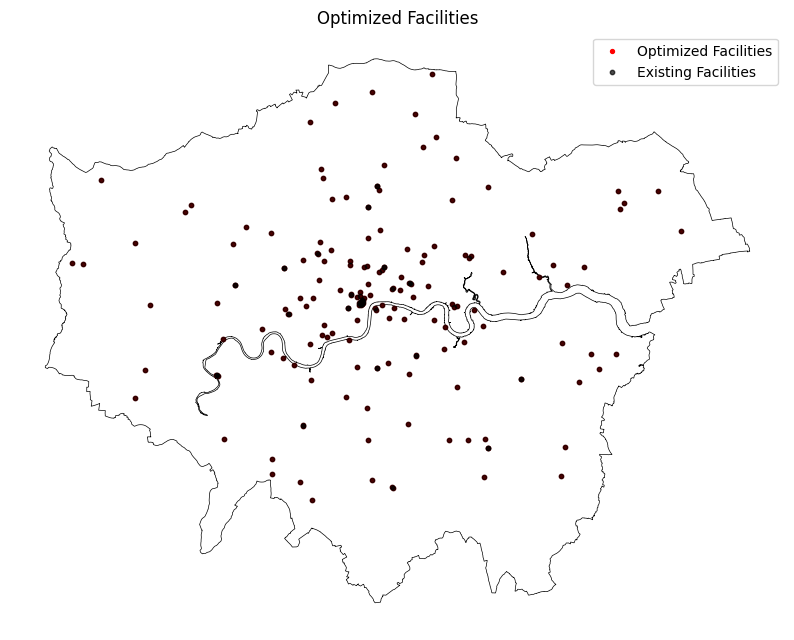

In [ ]:
# Save the optimized facilities to GeoDataFrame
optimized_df = gpd.GeoDataFrame(geometry=optimized_facility_points, crs='EPSG:27700')
#optimized_df.to_file('/path/to/optimized_facilities.geojson', driver='GeoJSON')

# Visualize optimization results
fig, ax = plt.subplots(figsize=(10, 10))
london_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=0.5, aspect='equal')


optimized_df.plot(ax=ax, color='red', markersize=8, label='Optimized Facilities')

# Draw existing facilities
combined_df.plot(
    ax=ax,
    color='black',
    markersize=10,
    label='Existing Facilities',
    edgecolor='k',
    alpha=0.7
)
#combined_df[combined_df['type'] == 'existing'].plot(column='type', ax=ax,color='black', markersize=5, label='Existing Facilities' edgecolor='k',  # 可选：为点添加边界颜色alpha=0.7  # 可选：设置点的透明度)
# Draw existing facilities
ax.set_title('Optimized Facilities')
ax.set_axis_off()
plt.legend()
plt.show()


In [ ]:

optimized_geom = set(optimized_df['geometry'])
combined_geom = set(combined_df['geometry'])

# Find points that exist in optimized_df but not in combined_df
only_in_optimized = optimized_df[~optimized_df['geometry'].isin(combined_df['geometry'])]

# Find points that exist in combined_df but not in optimized_df
only_in_combined = combined_df[~combined_df['geometry'].isin(optimized_df['geometry'])]

# Output results
print("Points only in optimized_df:")
print(only_in_optimized)

print("Points only in combined_df:")
print(only_in_combined)

# Note: Local search is to further optimise the objective function.
# The result may show that the global optimisation result is already the optimal solution,
# so the result is consistent with the previous point position:
# This algorithm still needs to be further improved
# The next step: rerun the Global Optimiser

Points only in optimized_df:
Empty GeoDataFrame
Columns: [geometry]
Index: []
Points only in combined_df:
Empty GeoDataFrame
Columns: [id, ref_no, name, pointx_cla, groupname, categoryna, classname, feature_ea, feature_no, pos_accura, uprn, topo_toid, topo_toid_, usrn, usrn_mi, distance, address_de, street_nam, locality, geographic, postcode, admin_boun, telephone_, url, brand, qualifier_, qualifie_1, provenance, supply_dat, poi_name, geometry]
Index: []

[0 rows x 31 columns]
